In [1]:
import numpy as np
import pandas as pd

In [2]:
from random import shuffle

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [4]:
train_dataset = pd.read_excel("train1.xlsx")
test_dataset = pd.read_excel("recog1.xlsx")

Подготовим хранилища для результатов

Предполагается, что у нас дан маркер таргета

In [5]:
target_col = "im"

In [6]:
train_target = np.array(train_dataset[target_col])
test_target = np.array(test_dataset[target_col])

In [7]:
train_target.__len__()

485

Так же предполагается, что я уже знаю, какой из параметров излишний

In [8]:
train_dataset.drop(columns = ['sys', target_col], inplace = True)
test_dataset.drop(columns = ['sys', target_col], inplace = True)

In [9]:
train_dataset.head(2)

,noma,ecg_id,MB0,MB1,MB2,MSEP,MSRP,MDP,MRR,MdSEP,...,msh22,msh23,msh24,msh25,msh26,msh27,msh28,msh29,msh30,msh31
0,26,45909,0,0,-1,0,0,0,0,721,...,6.987262,5.842897,6.949771,5.843638,6.935230,5.821854,6.910798,5.806775,6.897684,5.639776
1,35,46125,251,176,343,280,373,551,748,752,...,6.604633,5.460614,6.555808,5.436133,6.521528,5.415350,6.498449,5.406096,6.486808,5.397264


Базовая модель для обнаружения лучших объектов - catboost

In [10]:
from catboost import CatBoostClassifier

In [11]:
model = CatBoostClassifier(logging_level = "Silent")

Обнаружение лучших признаков


In [12]:
from sklearn.model_selection import KFold

In [13]:
folds = KFold(n_splits = 4, shuffle = True)

In [14]:
data = pd.DataFrame.copy(train_dataset)

In [15]:
values = []

In [16]:
columns = data.columns

In [17]:
for i in range(100):
    
    model = CatBoostClassifier(logging_level='Silent')
    
    cv = [[], [], [], []]
    cv_true = []
    
    for enum, indixes in enumerate(folds.split(data)):

        train_index = indixes[0]
        test_index = indixes[1]


        train = pd.DataFrame.copy(data.loc[train_index])
        test = pd.DataFrame.copy(data.loc[test_index])

        train_targ = train_target[train_index]
        test_targ = train_target[test_index]

        model.fit(train, train_targ)

        preds = model.predict(test)

        cv_true.append(roc_auc_score(test_targ, preds))

        for column in columns:

            hold = np.array(test[column])

            res = np.copy(hold)

            shuffle(res)

            test[column] = res

            preds_shuffle = model.predict(test)

            cv[enum].append(roc_auc_score(test_targ, preds_shuffle))

            test[column] = hold
            
    cv_check = [[], [], [], []]
    
    for i in range(4):
        true_i = cv_true[i]

        for enum, val in enumerate(cv[i]):

            if true_i > val:
                cv_check[i].append(enum)
    
    useful_features = []
    
    for item in cv_check:
        for val in item:
            if columns[val] not in useful_features:
                useful_features.append(columns[val])
                
    values.append(useful_features)

In [18]:
association = np.zeros(columns.__len__())

for enum, item in enumerate(columns):
    for best in values:
        if item in best:
            association[enum] += 1

In [19]:
order = np.argsort(association)[::-1]

In [20]:
valuable_columns = columns[order]

In [21]:
values_of_columns = association[order]

In [22]:
values_of_columns

array([100., 100., 100., 100.,  99.,  94.,  88.,  86.,  82.,  78.,  76.,
        74.,  74.,  73.,  67.,  65.,  63.,  61.,  59.,  55.,  50.,  47.,
        45.,  38.,  36.,  35.,  35.,  31.,  30.,  28.,  28.,  27.,  26.,
        25.,  25.,  25.,  25.,  24.,  24.,  24.,  24.,  23.,  22.,  22.,
        22.,  22.,  21.,  21.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,
        19.,  19.,  19.,  19.,  19.,  19.,  19.,  18.,  18.,  18.,  17.,
        17.,  17.,  17.,  17.,  16.,  16.,  15.,  15.,  15.,  14.,  14.,
        14.,  13.,  13.,  11.,  11.,  11.,  11.,  11.,  10.,   5.])

In [24]:
model = CatBoostClassifier()

In [25]:
model.fit(train_dataset, train_target)

Learning rate set to 0.013652
0:	learn: 0.6755047	total: 20.4ms	remaining: 20.4s
1:	learn: 0.6633947	total: 27.4ms	remaining: 13.7s
2:	learn: 0.6500839	total: 33.6ms	remaining: 11.2s
3:	learn: 0.6376672	total: 40.5ms	remaining: 10.1s
4:	learn: 0.6262111	total: 45.6ms	remaining: 9.07s
5:	learn: 0.6162183	total: 51.3ms	remaining: 8.5s
6:	learn: 0.6032528	total: 57.7ms	remaining: 8.19s
7:	learn: 0.5939021	total: 63.6ms	remaining: 7.89s
8:	learn: 0.5818660	total: 72.1ms	remaining: 7.94s
9:	learn: 0.5702196	total: 78.9ms	remaining: 7.82s
10:	learn: 0.5602328	total: 86ms	remaining: 7.73s
11:	learn: 0.5490322	total: 93.2ms	remaining: 7.67s
12:	learn: 0.5391298	total: 98ms	remaining: 7.44s
13:	learn: 0.5286578	total: 103ms	remaining: 7.23s
14:	learn: 0.5193071	total: 108ms	remaining: 7.1s
15:	learn: 0.5102157	total: 113ms	remaining: 6.95s
16:	learn: 0.4993774	total: 117ms	remaining: 6.79s
17:	learn: 0.4908306	total: 124ms	remaining: 6.74s
18:	learn: 0.4840171	total: 129ms	remaining: 6.65s
19:	

161:	learn: 0.1272212	total: 975ms	remaining: 5.04s
162:	learn: 0.1263048	total: 984ms	remaining: 5.05s
163:	learn: 0.1257067	total: 992ms	remaining: 5.06s
164:	learn: 0.1244851	total: 1000ms	remaining: 5.06s
165:	learn: 0.1240955	total: 1.01s	remaining: 5.06s
166:	learn: 0.1235398	total: 1.01s	remaining: 5.05s
167:	learn: 0.1229635	total: 1.02s	remaining: 5.04s
168:	learn: 0.1223700	total: 1.02s	remaining: 5.04s
169:	learn: 0.1218966	total: 1.03s	remaining: 5.03s
170:	learn: 0.1212331	total: 1.03s	remaining: 5.02s
171:	learn: 0.1208145	total: 1.04s	remaining: 5.01s
172:	learn: 0.1201689	total: 1.05s	remaining: 5.01s
173:	learn: 0.1195194	total: 1.05s	remaining: 5s
174:	learn: 0.1185889	total: 1.06s	remaining: 4.99s
175:	learn: 0.1180126	total: 1.06s	remaining: 4.98s
176:	learn: 0.1170415	total: 1.07s	remaining: 4.97s
177:	learn: 0.1161484	total: 1.07s	remaining: 4.96s
178:	learn: 0.1152683	total: 1.08s	remaining: 4.95s
179:	learn: 0.1148674	total: 1.08s	remaining: 4.95s
180:	learn: 0.

345:	learn: 0.0572238	total: 1.91s	remaining: 3.61s
346:	learn: 0.0568352	total: 1.91s	remaining: 3.6s
347:	learn: 0.0567355	total: 1.92s	remaining: 3.6s
348:	learn: 0.0566369	total: 1.93s	remaining: 3.59s
349:	learn: 0.0564286	total: 1.93s	remaining: 3.59s
350:	learn: 0.0562737	total: 1.94s	remaining: 3.58s
351:	learn: 0.0561260	total: 1.94s	remaining: 3.58s
352:	learn: 0.0557958	total: 1.95s	remaining: 3.57s
353:	learn: 0.0556594	total: 1.95s	remaining: 3.56s
354:	learn: 0.0555358	total: 1.96s	remaining: 3.56s
355:	learn: 0.0552605	total: 1.96s	remaining: 3.55s
356:	learn: 0.0550053	total: 1.97s	remaining: 3.54s
357:	learn: 0.0549100	total: 1.97s	remaining: 3.53s
358:	learn: 0.0547357	total: 1.98s	remaining: 3.53s
359:	learn: 0.0545791	total: 1.98s	remaining: 3.52s
360:	learn: 0.0543989	total: 1.98s	remaining: 3.51s
361:	learn: 0.0541928	total: 1.99s	remaining: 3.51s
362:	learn: 0.0539871	total: 1.99s	remaining: 3.5s
363:	learn: 0.0537872	total: 2s	remaining: 3.5s
364:	learn: 0.05370

510:	learn: 0.0349186	total: 2.69s	remaining: 2.58s
511:	learn: 0.0348899	total: 2.7s	remaining: 2.57s
512:	learn: 0.0348355	total: 2.7s	remaining: 2.57s
513:	learn: 0.0347034	total: 2.71s	remaining: 2.56s
514:	learn: 0.0346154	total: 2.71s	remaining: 2.55s
515:	learn: 0.0345326	total: 2.72s	remaining: 2.55s
516:	learn: 0.0344523	total: 2.72s	remaining: 2.54s
517:	learn: 0.0343500	total: 2.72s	remaining: 2.54s
518:	learn: 0.0342294	total: 2.73s	remaining: 2.53s
519:	learn: 0.0341143	total: 2.73s	remaining: 2.52s
520:	learn: 0.0340839	total: 2.74s	remaining: 2.52s
521:	learn: 0.0340483	total: 2.74s	remaining: 2.51s
522:	learn: 0.0339302	total: 2.74s	remaining: 2.5s
523:	learn: 0.0337242	total: 2.75s	remaining: 2.5s
524:	learn: 0.0335392	total: 2.75s	remaining: 2.49s
525:	learn: 0.0334602	total: 2.76s	remaining: 2.48s
526:	learn: 0.0333737	total: 2.76s	remaining: 2.48s
527:	learn: 0.0332972	total: 2.77s	remaining: 2.47s
528:	learn: 0.0331323	total: 2.77s	remaining: 2.47s
529:	learn: 0.03

694:	learn: 0.0211834	total: 3.67s	remaining: 1.61s
695:	learn: 0.0210968	total: 3.68s	remaining: 1.61s
696:	learn: 0.0210120	total: 3.69s	remaining: 1.6s
697:	learn: 0.0209603	total: 3.69s	remaining: 1.6s
698:	learn: 0.0209165	total: 3.7s	remaining: 1.59s
699:	learn: 0.0208983	total: 3.71s	remaining: 1.59s
700:	learn: 0.0208765	total: 3.71s	remaining: 1.58s
701:	learn: 0.0208409	total: 3.72s	remaining: 1.58s
702:	learn: 0.0208304	total: 3.73s	remaining: 1.57s
703:	learn: 0.0207894	total: 3.73s	remaining: 1.57s
704:	learn: 0.0207027	total: 3.74s	remaining: 1.57s
705:	learn: 0.0206092	total: 3.75s	remaining: 1.56s
706:	learn: 0.0205995	total: 3.75s	remaining: 1.56s
707:	learn: 0.0205504	total: 3.76s	remaining: 1.55s
708:	learn: 0.0204709	total: 3.77s	remaining: 1.55s
709:	learn: 0.0204496	total: 3.77s	remaining: 1.54s
710:	learn: 0.0204085	total: 3.78s	remaining: 1.54s
711:	learn: 0.0203206	total: 3.79s	remaining: 1.53s
712:	learn: 0.0202744	total: 3.79s	remaining: 1.53s
713:	learn: 0.0

890:	learn: 0.0137114	total: 4.66s	remaining: 570ms
891:	learn: 0.0136921	total: 4.66s	remaining: 565ms
892:	learn: 0.0136820	total: 4.67s	remaining: 560ms
893:	learn: 0.0136719	total: 4.67s	remaining: 554ms
894:	learn: 0.0136339	total: 4.68s	remaining: 549ms
895:	learn: 0.0135982	total: 4.68s	remaining: 544ms
896:	learn: 0.0135579	total: 4.69s	remaining: 538ms
897:	learn: 0.0135335	total: 4.69s	remaining: 533ms
898:	learn: 0.0135228	total: 4.7s	remaining: 528ms
899:	learn: 0.0135154	total: 4.7s	remaining: 522ms
900:	learn: 0.0135048	total: 4.71s	remaining: 517ms
901:	learn: 0.0134834	total: 4.71s	remaining: 512ms
902:	learn: 0.0134610	total: 4.71s	remaining: 507ms
903:	learn: 0.0134275	total: 4.72s	remaining: 501ms
904:	learn: 0.0134022	total: 4.72s	remaining: 496ms
905:	learn: 0.0133747	total: 4.73s	remaining: 491ms
906:	learn: 0.0133666	total: 4.73s	remaining: 485ms
907:	learn: 0.0133176	total: 4.74s	remaining: 480ms
908:	learn: 0.0133053	total: 4.74s	remaining: 475ms
909:	learn: 0.

In [29]:
catboost_importance = model.get_feature_importance()

In [34]:
catboost_sorted = np.argsort(catboost_importance)[::-1]

In [35]:
catboost_columns = train_dataset.columns[catboost_sorted]

In [37]:
catboost_values = catboost_importance[catboost_sorted]

In [38]:
catboost_values = catboost_values * 100 / catboost_values.max()

array([100.        ,  91.37088035,  53.6553345 ,  36.07874432,
        26.34511517,  21.20688531,  20.76386106,  18.75947397,
        17.75637293,  17.307038  ,  15.7793019 ,  15.71695184,
        15.6381875 ,  14.3090429 ,  13.2181759 ,  12.63409663,
        12.22157873,  12.09450379,  11.86215437,  10.66176458,
        10.02442962,   9.56460133,   8.99621429,   7.12528585,
         6.69630717,   6.530324  ,   6.11282767,   6.10274344,
         5.98365193,   5.86161846,   5.58964624,   5.51142961,
         5.47845163,   5.29671224,   5.1751015 ,   4.97180622,
         4.86572442,   4.8477425 ,   4.78715752,   4.56737547,
         4.53424821,   4.48651563,   4.45440603,   4.41469334,
         4.29823882,   4.16719586,   4.1353836 ,   4.0227218 ,
         3.99495834,   3.91082861,   3.90095631,   3.85072403,
         3.77915929,   3.71893981,   3.64623441,   3.6401896 ,
         3.50183114,   3.39387753,   3.39218604,   3.28341373,
         3.26869802,   3.20603426,   3.16467848,   3.07

In [41]:
import matplotlib.pyplot as plt

In [48]:
i = -1

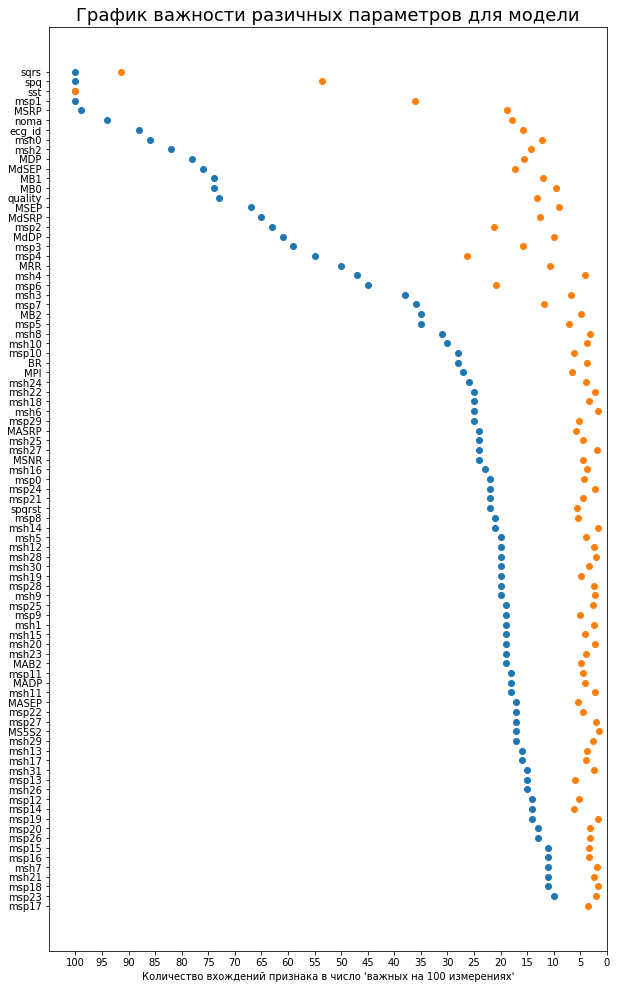

In [49]:
fig = plt.figure(figsize=[10, 17])

plt.scatter(values_of_columns[:i], valuable_columns[:i])
plt.scatter(catboost_values[:i], catboost_columns[:i])

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xticks(np.arange(21) * 5)
plt.xlim(105, 0)

plt.title("График важности разичных параметров для модели", fontsize=18)
plt.xlabel("Количество вхождений признака в число 'важных на 100 измерениях'")

#plt.savefig("Images/Feature_importance.png")

plt.show()

Выберем столбцы, которые оставим

In [280]:
kept_columns = valuable_columns[values_of_columns >= 0]
kept_values = values_of_columns[values_of_columns >= 0]

In [281]:
train_kept = pd.DataFrame.copy(train_dataset.loc[:, kept_columns])
test_kept = pd.DataFrame.copy(test_dataset.loc[:, kept_columns])

In [282]:
kept_columns

Index(['msp1', 'sst', 'sqrs', 'noma', 'ecg_id', 'spq', 'quality', 'MSRP',
       'msp3', 'msh0', 'msp2', 'msp4', 'MDP', 'msp6', 'MSEP', 'MdSEP',
       'spqrst', 'MRR', 'MB1', 'msp0', 'MdDP', 'msp5', 'msh2', 'MADP', 'MB0',
       'MdSRP', 'msh31', 'msh25', 'MASRP', 'msp29', 'MASEP', 'MPI', 'MAB2',
       'msp24', 'msh23', 'BR', 'MSNR', 'msh12', 'msh8', 'msp9', 'msp7',
       'msh10', 'msh4', 'msh27', 'msp10', 'MB2', 'msp27', 'msp28', 'msp23',
       'msh24', 'msh1', 'msp26', 'msh19', 'msh17', 'msh28', 'msh29', 'msh15',
       'msh11', 'msh16', 'msh21', 'msp21', 'MS5S2', 'msp13', 'msp25', 'msp8',
       'msh14', 'msh3', 'msh13', 'msp15', 'msp12', 'msp20', 'msh30', 'msh6',
       'msh22', 'msh18', 'msh20', 'msp22', 'msp19', 'msh26', 'msh5', 'msh9',
       'msh7', 'msp11', 'msp16', 'msp14', 'msp18', 'msp17'],
      dtype='object')

In [283]:
kept_values

array([100., 100., 100.,  99.,  99.,  96.,  96.,  96.,  93.,  90.,  87.,
        86.,  83.,  81.,  81.,  76.,  71.,  71.,  71.,  71.,  71.,  69.,
        68.,  66.,  65.,  65.,  58.,  58.,  56.,  56.,  53.,  51.,  50.,
        49.,  48.,  48.,  48.,  47.,  47.,  46.,  45.,  45.,  45.,  44.,
        44.,  44.,  44.,  43.,  43.,  42.,  42.,  42.,  41.,  40.,  40.,
        40.,  40.,  39.,  38.,  38.,  38.,  37.,  37.,  36.,  36.,  36.,
        36.,  35.,  35.,  35.,  34.,  34.,  33.,  33.,  32.,  32.,  29.,
        29.,  29.,  27.,  26.,  26.,  26.,  25.,  24.,  24.,  21.])

## Введем преобразование к матрице попарных расстояний:

In [191]:
def numeric_features(feat_line):
    
    pre_arr = np.absolute(feat_line[None, :] - feat_line[:, None])
    max_val = pre_arr.max()
    
    return pre_arr / pre_arr.max()

def build_distances(train_line, test_line):
    
    train_pre_arr = np.absolute(train_line[None, :] - train_line[:, None])
    test_pre_arr = np.absolute(train_line[None, :] - test_line[:, None])
    
    train_max = train_pre_arr.max()

    return train_pre_arr / train_max, test_pre_arr / train_max

def recombinate(arr_list, names_list):
    # also uses features and percentiles lists
    
    pairwise = np.zeros(arr_list[0].shape)
    
    for enum, item in enumerate(names_list):
        
        position = np.where(features == item)[0][0]
        pairwise += percentiles[position] / 100 * arr_list[enum]
        
    return pairwise

In [192]:
def recombination(train_df, test_df,
                  features, percentiles,
                  filling_diag = 'mean', 
                  using_percentiles = True):
    # пока что уберем из рассмотрения столбец Number, т.к. я не знаю, что с ним делать
    
    columns = train_df.columns
    
    train_len = train_df.__len__()
    test_len = test_df.__len__()
    
    train_pairwise = np.zeros((train_len, train_len))
    test_pairwise = np.zeros((test_len, train_len))
    
    for col in columns:
        
        train_arr = np.array(train_df[col])
        test_arr = np.array(test_df[col])
        
        train_dist, test_dist = build_distances(train_arr, test_arr)
        
        position = np.where(features == col)[0][0]
        
        if using_percentiles:
        
            train_pairwise += percentiles[position] / 100 * train_dist
            test_pairwise += percentiles[position] / 100 * test_dist

        else:
            
            train_pairwise += train_dist
            test_pairwise += test_dist
            
    if filling_diag == 'mean':
        
        np.fill_diagonal(train_pairwise, np.mean(train_pairwise))
        
    if filling_diag == 'median':
        
        np.fill_diagonal(train_pairwise, np.median(train_pairwise))
        
    if filling_diag == 'max':
        
        np.fill_diagonal(train_pairwise, np.max(train_pairwise))
        
    return train_pairwise, test_pairwise

## As a benchmark, i'll use just boosting:

In [284]:
values_1 = []
values_2 = []
values_3 = []
values_4 = []
values_5 = []
values_6 = []
values_7 = []
iters = [100, 200, 300, 400, 500,
         600, 700, 800, 900, 1000, 
         1500, 2000, 2500, 3000, 4000, 5000, 6000]

In [285]:
train_dataset.head(2)

,noma,ecg_id,MB0,MB1,MB2,MSEP,MSRP,MDP,MRR,MdSEP,...,msh22,msh23,msh24,msh25,msh26,msh27,msh28,msh29,msh30,msh31
0,26,45909,0,0,-1,0,0,0,0,721,...,6.987262,5.842897,6.949771,5.843638,6.935230,5.821854,6.910798,5.806775,6.897684,5.639776
1,35,46125,251,176,343,280,373,551,748,752,...,6.604633,5.460614,6.555808,5.436133,6.521528,5.415350,6.498449,5.406096,6.486808,5.397264


In [286]:
train_normalized = (train_dataset - train_dataset.mean()) / train_dataset.std()
test_normalized = (test_dataset - test_dataset.mean()) / test_dataset.std()

In [287]:
kept_norm = (train_kept - train_kept.mean()) / train_kept.std()
kept_test_norm = (test_kept - test_kept.mean()) / test_kept.std()

In [288]:
train_f_pair, test_f_pair = recombination(train_dataset,
                                          test_dataset,
                                          valuable_columns,
                                          values_of_columns,
                                          filling_diag = 'mean',
                                          using_percentiles = False)

In [289]:
train_pair, test_pair = recombination(train_kept,
                                      test_kept,
                                      valuable_columns,
                                      values_of_columns,
                                      filling_diag = 'mean',
                                      using_percentiles = False
                                      )

In [290]:
train_p_pair, test_p_pair = recombination(train_kept,
                                          test_kept,
                                          valuable_columns,
                                          values_of_columns,
                                          filling_diag = 'mean',
                                          using_percentiles = True)

In [266]:
for it in iters:
    
    model = CatBoostClassifier(logging_level = "Silent",
                               iterations = it)
    
    model.fit(train_dataset, train_target)
    preds_1 = model.predict_proba(test_dataset)[:, 1]    
    values_1.append(roc_auc_score(test_target, preds_1))
    
    model.fit(train_normalized, train_target)
    preds_2 = model.predict_proba(test_normalized)[:, 1]    
    values_2.append(roc_auc_score(test_target, preds_2))
    
        
    model.fit(train_kept, train_target)
    preds_7 = model.predict_proba(test_kept)[:, 1]    
    values_7.append(roc_auc_score(test_target, preds_7))
    
        
    model.fit(train_f_pair, train_target)
    preds_4 = model.predict_proba(test_f_pair)[:, 1]    
    values_4.append(roc_auc_score(test_target, preds_4))

    
    model.fit(kept_norm, train_target)
    preds_3 = model.predict_proba(kept_test_norm)[:, 1]    
    values_3.append(roc_auc_score(test_target, preds_3))

    model.fit(train_pair, train_target)
    preds_5 = model.predict_proba(test_pair)[:, 1]    
    values_5.append(roc_auc_score(test_target, preds_5))
    
    model.fit(train_p_pair, train_target)
    preds_6 = model.predict_proba(test_p_pair)[:, 1]
    values_6.append(roc_auc_score(test_target, preds_6))

    print(it)

100
200
300
400
500
600
700
800
900
1000
1500
2000
2500


KeyboardInterrupt: 

In [267]:
iters = iters[:-4]
iters

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500]

In [268]:
import matplotlib.pyplot as plt

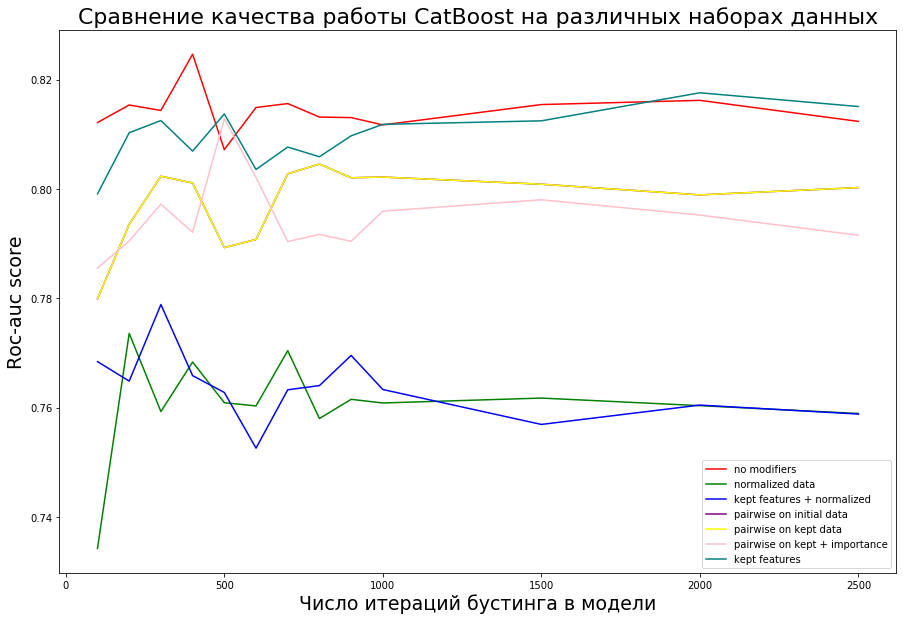

In [269]:
plt.figure(figsize = [15, 10])

plt.plot(iters, values_1, color = 'red', label = 'no modifiers' )
plt.plot(iters, values_2, color = 'green', label = 'normalized data')
plt.plot(iters, values_3, color = 'blue', label = 'kept features + normalized')
plt.plot(iters, values_4, color = 'purple', label = 'pairwise on initial data')
plt.plot(iters, values_5, color = 'yellow', label = 'pairwise on kept data')
plt.plot(iters, values_6, color = 'pink', label = 'pairwise on kept + importance')
plt.plot(iters, values_7, color = 'teal', label = 'kept features')
plt.legend()

plt.title("Сравнение качества работы CatBoost на различных наборах данных", fontsize=22)
plt.xlabel("Число итераций бустинга в модели", fontsize=19)
plt.ylabel("Roc-auc score", fontsize=19)

plt.savefig("Images/4nd_catboost.png")

plt.show()

## Как видно, отбор параметров не сильно помогает работе catboost, т.к. в нем встроен собственный подбор параметров (результаты которого схожи с полученными мною)

Попробуем применить какую-нибудь другую популярную модель - randomforest

In [141]:
from sklearn.ensemble import RandomForestClassifier

In [142]:
model_forest = RandomForestClassifier()

In [143]:
values_10 = []
values_20 = []
values_30 = []
values_40 = []
values_50 = []
values_60 = []
values_70 = []

In [156]:
values_30 = []
values_50 = []
values_60 = []

In [157]:
for it in iters:
    
    model = RandomForestClassifier(n_estimators=it, n_jobs= -1)
    
    """
    
    model.fit(train_dataset, train_target)
    preds_1 = model.predict_proba(test_dataset)[:, 1]    
    values_10.append(roc_auc_score(test_target, preds_1))
    
    model.fit(train_normalized, train_target)
    preds_2 = model.predict_proba(test_normalized)[:, 1]    
    values_20.append(roc_auc_score(test_target, preds_2))
    
    model.fit(train_kept, train_target)
    preds_7 = model.predict_proba(test_kept)[:, 1]    
    values_70.append(roc_auc_score(test_target, preds_7))
    
    model.fit(train_f_pair, train_target)
    preds_4 = model.predict_proba(test_f_pair)[:, 1]    
    values_40.append(roc_auc_score(test_target, preds_4))
    
    """
    
    model.fit(kept_norm, train_target)
    preds_3 = model.predict_proba(kept_test_norm)[:, 1]    
    values_30.append(roc_auc_score(test_target, preds_3))
    

    model.fit(train_pair, train_target)
    preds_5 = model.predict_proba(test_pair)[:, 1]    
    values_50.append(roc_auc_score(test_target, preds_5))
    
    model.fit(train_p_pair, train_target)
    preds_6 = model.predict_proba(test_p_pair)[:, 1]
    values_60.append(roc_auc_score(test_target, preds_6))
    

    
    print(it)

100
200
300
400
500
600
700
800
900
1000
1500
2000
2500
3000
4000
5000
6000


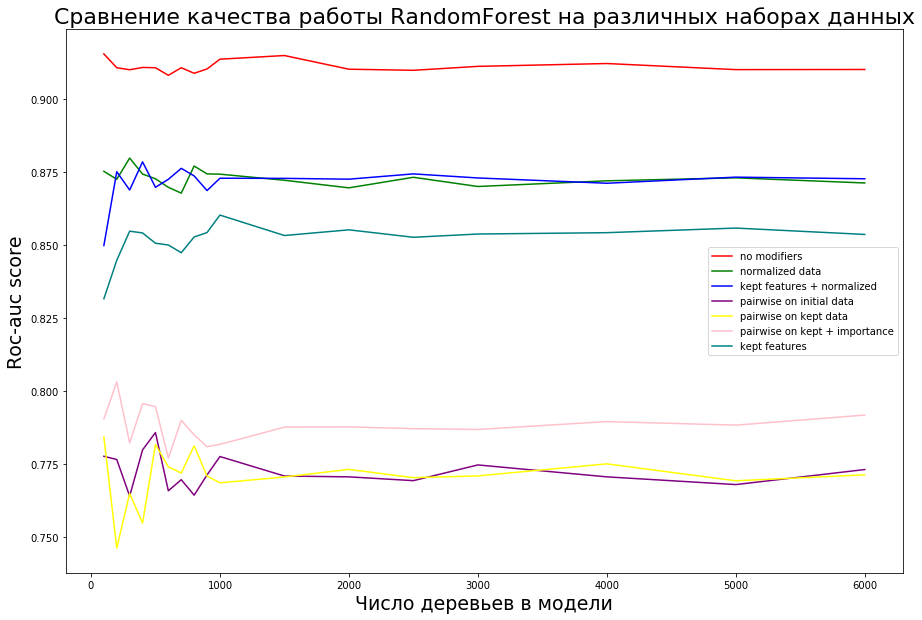

In [158]:
plt.figure(figsize = [15, 10])

plt.plot(iters, values_10, color = 'red', label = 'no modifiers' )
plt.plot(iters, values_20, color = 'green', label = 'normalized data')
plt.plot(iters, values_30, color = 'blue', label = 'kept features + normalized')
plt.plot(iters, values_40, color = 'purple', label = 'pairwise on initial data')
plt.plot(iters, values_50, color = 'yellow', label = 'pairwise on kept data')
plt.plot(iters, values_60, color = 'pink', label = 'pairwise on kept + importance')
plt.plot(iters, values_70, color = 'teal', label = 'kept features')
plt.legend()

plt.title("Сравнение качества работы RandomForest на различных наборах данных", fontsize=22)
plt.xlabel("Число деревьев в модели", fontsize=19)
plt.ylabel("Roc-auc score", fontsize=19)

plt.savefig("Images/4th_forest_3.png")

plt.show()

мда


## попробуем ещё применить lgbm

In [291]:
from lightgbm import LGBMClassifier

In [292]:
values_100 = []
values_200 = []
values_300 = []
values_400 = []
values_500 = []
values_600 = []
values_700 = []

In [293]:
for it in iters:
    
    model = LGBMClassifier(n_estimators=it, n_jobs= - 1)

    model.fit(train_dataset, train_target)
    preds_1 = model.predict_proba(test_dataset)[:, 1]    
    values_100.append(roc_auc_score(test_target, preds_1))
    
    model.fit(train_normalized, train_target)
    preds_2 = model.predict_proba(test_normalized)[:, 1]    
    values_200.append(roc_auc_score(test_target, preds_2))
    
    model.fit(train_kept, train_target)
    preds_7 = model.predict_proba(test_kept)[:, 1]    
    values_700.append(roc_auc_score(test_target, preds_7))
    
    model.fit(train_f_pair, train_target)
    preds_4 = model.predict_proba(test_f_pair)[:, 1]    
    values_400.append(roc_auc_score(test_target, preds_4))
    
    model.fit(kept_norm, train_target)
    preds_3 = model.predict_proba(kept_test_norm)[:, 1]    
    values_300.append(roc_auc_score(test_target, preds_3))
    

    model.fit(train_pair, train_target)
    preds_5 = model.predict_proba(test_pair)[:, 1]    
    values_500.append(roc_auc_score(test_target, preds_5))
    
    model.fit(train_p_pair, train_target)
    preds_6 = model.predict_proba(test_p_pair)[:, 1]
    values_600.append(roc_auc_score(test_target, preds_6))
    

    
    print(it)

100
200
300
400
500
600
700
800
900
1000
1500
2000
2500
3000
4000
5000
6000


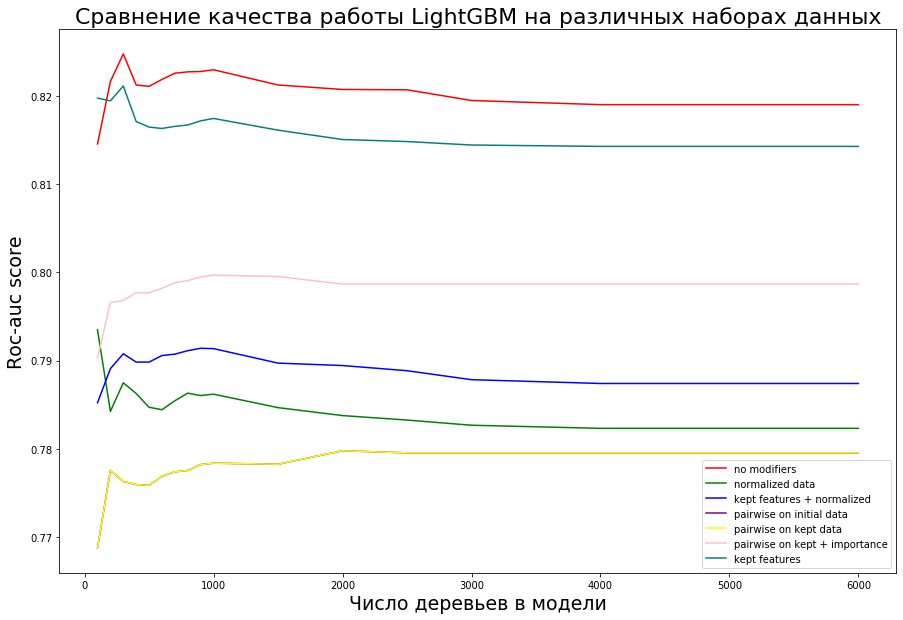

In [294]:
plt.figure(figsize = [15, 10])

plt.plot(iters, values_100, color = 'red', label = 'no modifiers' )
plt.plot(iters, values_200, color = 'green', label = 'normalized data')
plt.plot(iters, values_300, color = 'blue', label = 'kept features + normalized')
plt.plot(iters, values_400, color = 'purple', label = 'pairwise on initial data')
plt.plot(iters, values_500, color = 'yellow', label = 'pairwise on kept data')
plt.plot(iters, values_600, color = 'pink', label = 'pairwise on kept + importance')
plt.plot(iters, values_700, color = 'teal', label = 'kept features')
plt.legend()

plt.title("Сравнение качества работы LightGBM на различных наборах данных", fontsize=22)
plt.xlabel("Число деревьев в модели", fontsize=19)
plt.ylabel("Roc-auc score", fontsize=19)

plt.savefig("Images/2th_lgbm.png")

plt.show()